In [1]:
import os
import sys
import json
from datetime import datetime

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

In [2]:
# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment_gym as env_gym
import environment_gym_rs3 as env_gym_rs3
import utilities as util

# Load the TensorBoard extension
# %reload_ext tensorboard

## Reward Shaping Method 3

- Remove lane swtich penalty
- Apply reward to good lane swtich
- Time penalty is changed from "distance covered - 10" to "2 * distance - 10"

### Train Model 5

In [6]:
# Initialize and vectorize the environment
env = environment_gym_rs3.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
eval_env = Monitor(environment_gym_rs3.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/ppo_rs3_baseline_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env,
            verbose = 1,
            tensorboard_log = log_dir
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_rs4_baseline_model/PPO_4
Eval num_timesteps=1000, episode_reward=-12125.00 +/- 12262.36
Episode length: 1604.20 +/- 1223.08
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.6e+03   |
|    mean_reward     | -1.21e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-1784.00 +/- 3425.38
Episode length: 574.00 +/- 336.64
----------------------------------
| eval/              |           |
|    mean_ep_length  | 574       |
|    mean_reward     | -1.78e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.78e+03  |
|    ep_rew_mean     | -9.

### Test Model 5

In [ ]:
# Load the best baseline model
log_dir = "./logs/ppo_rs3_baseline_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = PPO.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [ ]:
# Test the model
num_episodes = 1000
file_name = 'ppo_rs3_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

### Analysis of Model 5

Average reward of 1000 episodes is -12590.
Average timesteps of 1000 episodes is 1110.


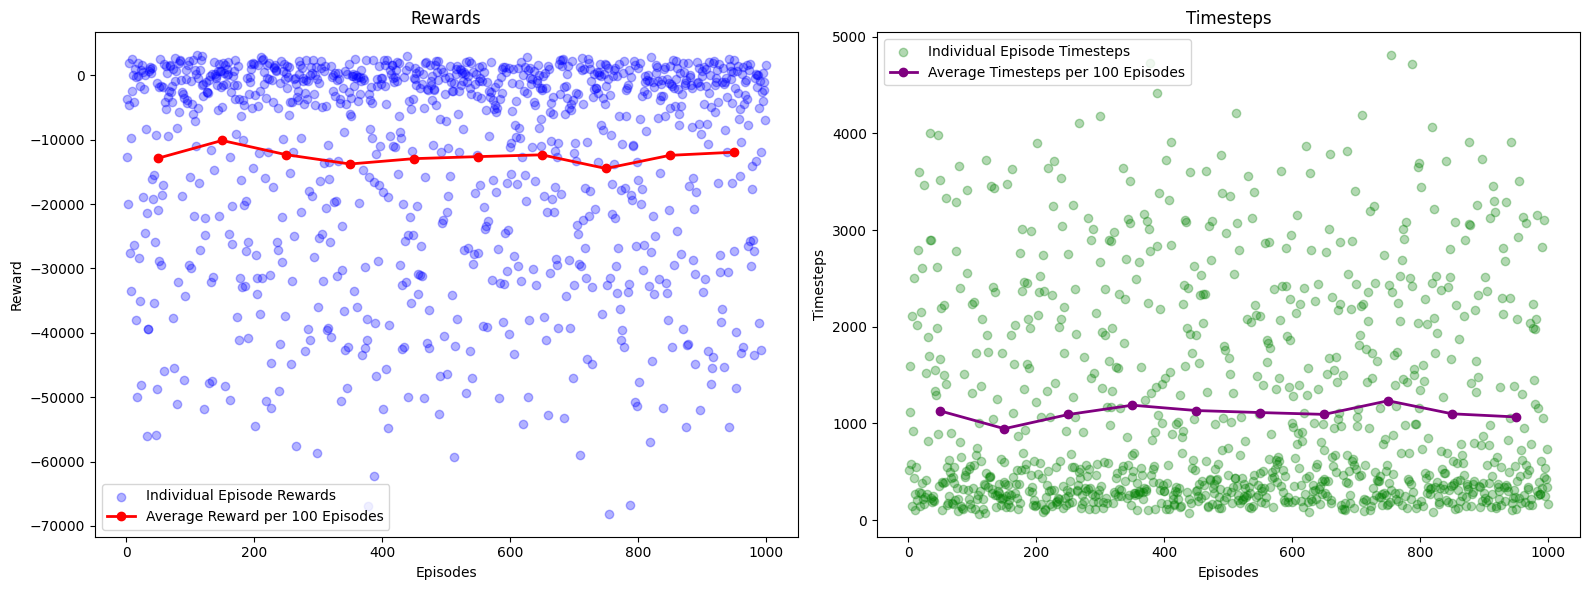

In [27]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

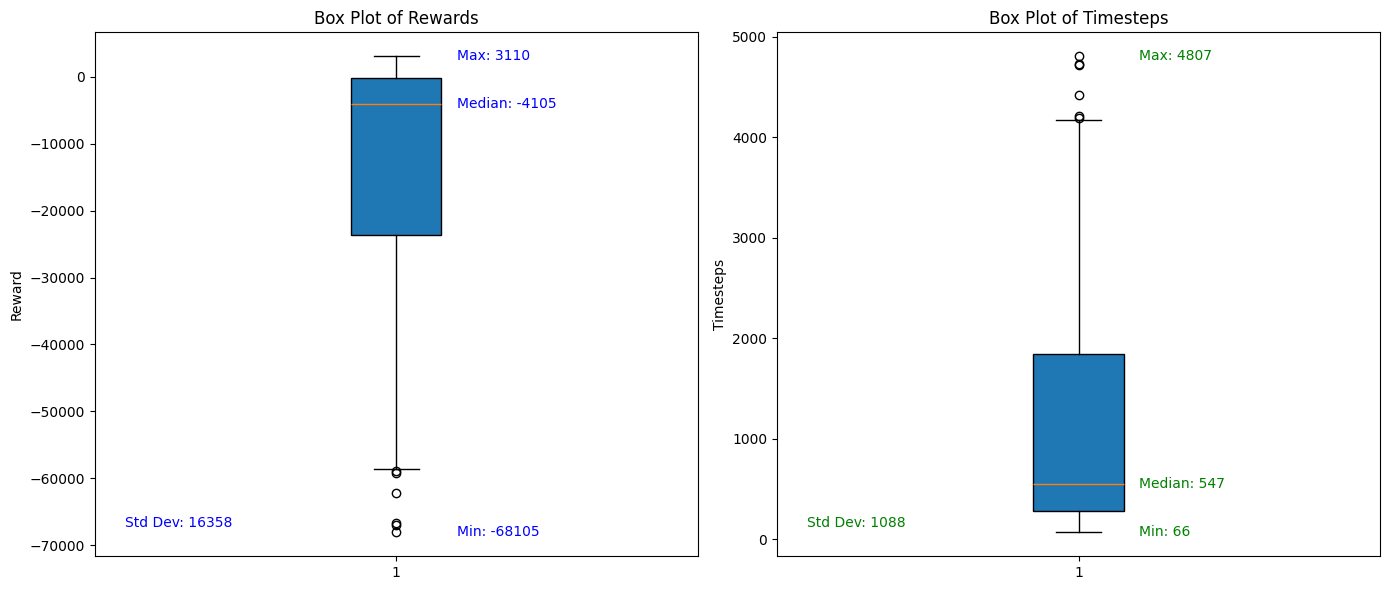

In [3]:
util.plot_test_boxplots(json_file=file_name)

In [31]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)

Total actions across 1000 episodes: 1109869
Action -1: 0.0%
Action 0: 0.0%
Action 1: 100.0%

Total timesteps across 1000 episodes (including initial states): 1110869
Lane 1:
  78.6% of timesteps had a clearance rate less than 5
  88.1% of timesteps had a clearance rate less than 10
Lane 2:
  78.4% of timesteps had a clearance rate less than 5
  88.2% of timesteps had a clearance rate less than 10
Lane 3:
  78.4% of timesteps had a clearance rate less than 5
  88.4% of timesteps had a clearance rate less than 10
Lane 4:
  78.7% of timesteps had a clearance rate less than 5
  88.8% of timesteps had a clearance rate less than 10
Lane 5:
  79.1% of timesteps had a clearance rate less than 5
  89.0% of timesteps had a clearance rate less than 10


### Train Model 6 (Fine-tune Model 5)

In [17]:
# Initialize and vectorize the environment
env = env_gym_rs3.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
eval_env = Monitor(env_gym_rs3.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/ppo_rs3_finetune_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env,
            learning_rate=0.0005,
            ent_coef=0.1,
            clip_range=0.3,
            n_steps=4096,
            batch_size=256,
            gamma=0.3,
            verbose = 1,
            tensorboard_log = log_dir
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=False,
    render=False
)

# Train the PPO model
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_rs4_finetune_model/PPO_4
Eval num_timesteps=1000, episode_reward=-13321.00 +/- 15973.50
Episode length: 1305.60 +/- 1197.20
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.31e+03  |
|    mean_reward     | -1.33e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-2744.00 +/- 3895.73
Episode length: 510.60 +/- 288.81
----------------------------------
| eval/              |           |
|    mean_ep_length  | 511       |
|    mean_reward     | -2.74e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
Eval num_timesteps=3000, episode_reward=-15065.00 +/- 17470.41
Episode length: 1434.40 +/- 1305.64
--------------------------------

In [1]:
# Start TensorBoard to monitor logs
# %tensorboard --logdir ./logs/ppo_rs3_finetune_model --port=5005

### Test Model 6

In [ ]:
# Load the best baseline model
log_dir = "./logs/ppo_rs3_finetune_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = PPO.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [ ]:
# Test the model
num_episodes = 1000
file_name = 'ppo_rs3_finetune_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

### Analysis of Model 6

Average reward of 1000 episodes is -11486.
Average timesteps of 1000 episodes is 1037.


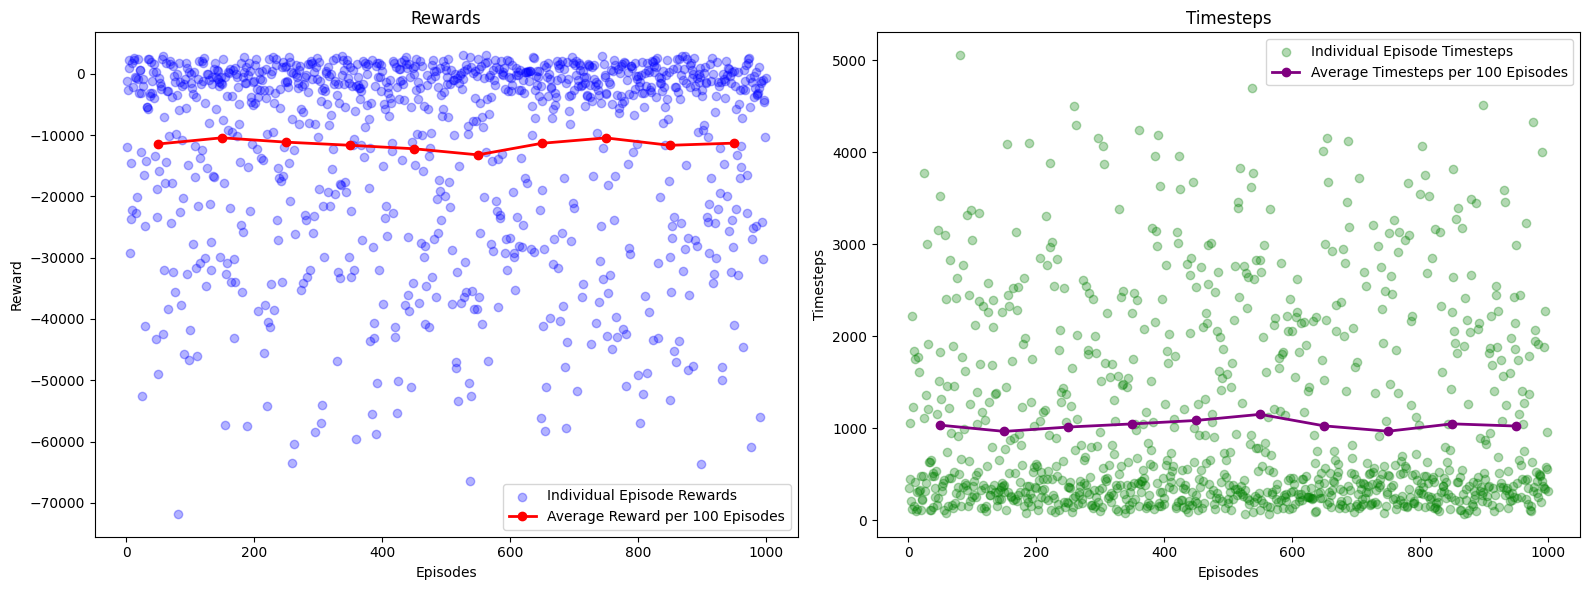

In [29]:
util.plot_test_results(rewards=rewards, timesteps=timesteps, interval=100)

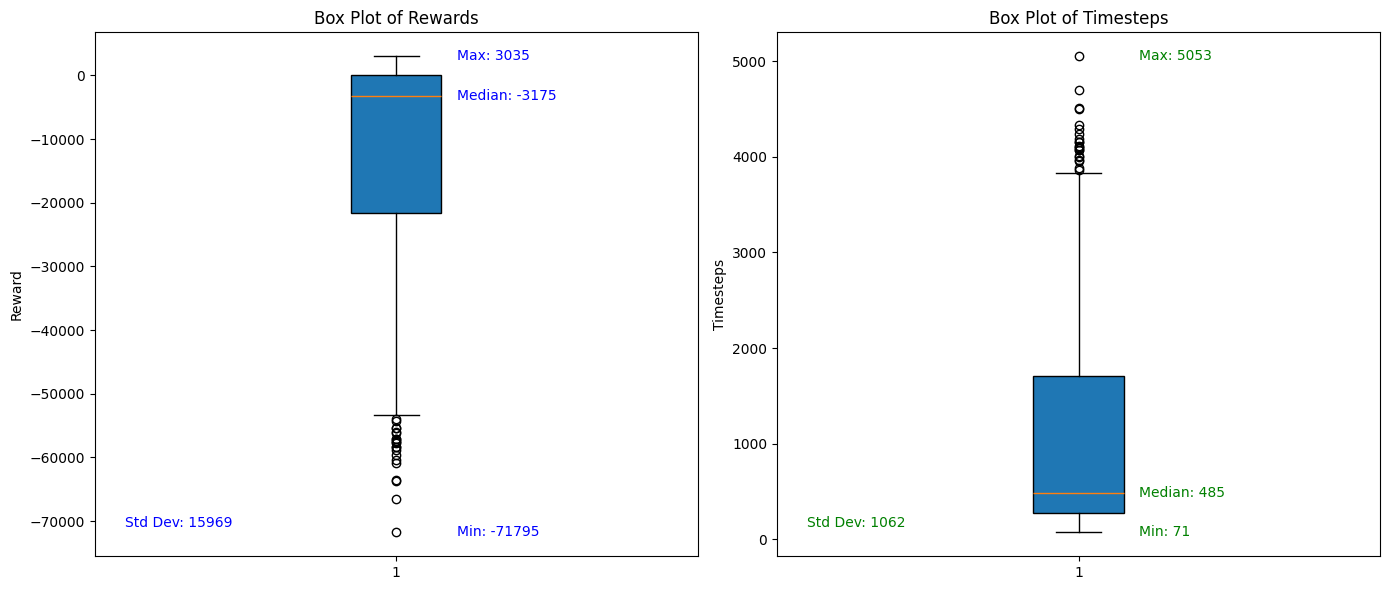

In [4]:
file_name = 'ppo_rs3_finetune_model_test_log.json'
util.plot_test_boxplots(json_file=file_name)

In [30]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)

Total actions across 1000 episodes: 1036509
Action -1: 0.2%
Action 0: 0.0%
Action 1: 99.8%

Total timesteps across 1000 episodes (including initial states): 1037509
Lane 1:
  77.2% of timesteps had a clearance rate less than 5
  87.5% of timesteps had a clearance rate less than 10
Lane 2:
  76.8% of timesteps had a clearance rate less than 5
  87.4% of timesteps had a clearance rate less than 10
Lane 3:
  76.7% of timesteps had a clearance rate less than 5
  87.4% of timesteps had a clearance rate less than 10
Lane 4:
  76.8% of timesteps had a clearance rate less than 5
  87.7% of timesteps had a clearance rate less than 10
Lane 5:
  77.2% of timesteps had a clearance rate less than 5
  88.0% of timesteps had a clearance rate less than 10
